# Create a logistic regression model to predict TP53 mutation from gene expression data in TCGA

In [1]:
import datetime
import json
import os
import time

from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from dask_searchcv import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from vega import Vega
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils import fill_spec_with_data, get_model_coefficients, get_genes_coefficients

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a classifier with multiple genes filtered by two diseases 
# Example:
# gene_ids = ['7157', '7158', '7159', '7161']

# Information passed into the notebook is stored in environment variables
gene_ids = os.environ.get('gene_ids')
if not gene_ids:
    gene_ids = ['7157'] # TP53 is the default
else:
    gene_ids = gene_ids.split('-')
    
disease_acronyms = os.environ.get('disease_acronyms')

if not disease_acronyms:
    disease_acronyms = None # use all of the diseases as default
    # disease_acronyms = ['LUAD', 'BLCA']
else:
    disease_acronyms = disease_acronyms.split('-')
    
print("Genes: " + str(gene_ids))
print("Diseases: " + str(disease_acronyms))

Genes: ['7157']
Diseases: None


*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [4]:
path = os.path.join('download', 'expression-matrix.tsv.bz2')
expression_df = pd.read_table(path, index_col=0)

path = os.path.join('download', 'mutation-matrix.tsv.bz2')
mutation_df = pd.read_table(path, index_col=0)

path = os.path.join('download', 'covariates.tsv')
covariate_df = pd.read_table(path, index_col=0)

path = os.path.join('download', 'expression-genes.tsv')
expression_genes_df = pd.read_table(path, index_col=0)

In [5]:
# Select acronym_x and n_mutations_log1p covariates only
disease_cols = [col for col in covariate_df.columns if col.startswith('acronym_')]

# Filter covariate columns by disease if a list was provided
if disease_acronyms:
    disease_cols = [col for col in disease_cols if col.endswith(tuple(disease_acronyms))]
    
selected_cols = disease_cols + ['n_mutations_log1p']
covariate_df = covariate_df[selected_cols]

In [6]:
# Filter the rows by disease type
# subsection of columns with row-wise max
has_disease = covariate_df[disease_cols].max(axis=1) > 0
covariate_df = covariate_df[has_disease]

In [7]:
# filter by sample_id
expression_df = expression_df[expression_df.index.isin(covariate_df.index)]

# filter by sample_id
mutation_df = mutation_df[mutation_df.index.isin(covariate_df.index)]

In [8]:
# The series holds Gene Mutation Status for each sample
# Take max of mutation status, meaning if any of the genes mutated the value should be 1
y = mutation_df[gene_ids].max(axis=1)
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
dtype: int64

In [9]:
print('Gene expression matrix shape: {}'.format(expression_df.shape))
print('Covariates matrix shape: {}'.format(covariate_df.shape))

Gene expression matrix shape: (7306, 20468)
Covariates matrix shape: (7306, 33)


## Set aside 10% of the data for testing

In [10]:
# Typically, this type of split can only be done 
# for genes where the number of mutations is large enough
X = pd.concat([covariate_df, expression_df], axis='columns')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Here are the percentage of tumors with TP53
y.value_counts(True)

0    0.645907
1    0.354093
dtype: float64

## Feature selection

In [11]:
def select_feature_set_columns(X, feature_set):
    """
    Select the feature set for the different models within the pipeline
    """
    n_covariates = len(covariate_df.columns)
    if feature_set == 'covariates':
        return X[:, :n_covariates]
    if feature_set == 'expressions':
        return X[:, n_covariates:]
    raise ValueError('feature_set not supported: {}'.format(feature_set))

# Creates the expression features by standarizing them and running PCA
# Because the expressions matrix is so large, we preprocess with PCA
# The amount of variance in the data captured by ~100 components is high
expression_features = Pipeline([
    ('select_features', FunctionTransformer(select_feature_set_columns,
        kw_args={'feature_set': 'expressions'})),
    ('standardize', StandardScaler()),
    ('pca', PCA())
])

# Creates the covariate features by selecting and standardizing them
covariate_features = Pipeline([
    ('select_features', FunctionTransformer(select_feature_set_columns,
        kw_args={'feature_set': 'covariates'})),
    ('standardize', StandardScaler())
])

## Elastic net classifier and model paraemeters

In [12]:
# Parameter Sweep for Hyperparameters
n_components_list = [50, 100]
regularization_alpha_list = [10 ** x for x in range(-3, 1)]
regularization_l1_ratio = 0.15

param_grids = {
    'full': {
        'features__expressions__pca__n_components' : n_components_list,
        'classify__alpha': regularization_alpha_list
    },
    'expressions': {
        'features__expressions__pca__n_components' : n_components_list,
        'classify__alpha': regularization_alpha_list
    },
    'covariates': {
        'classify__alpha': regularization_alpha_list
    }
}

# Classifier: Elastic Net
classifier = SGDClassifier(penalty='elasticnet',
                           l1_ratio=regularization_l1_ratio,
                           loss='log', 
                           class_weight='balanced',
                           random_state=0)

## Define pipeline and cross validation

In [13]:
# Full model pipelines
pipeline_definitions = {
    'full': Pipeline([
        ('features', FeatureUnion([
            ('expressions', expression_features),
            ('covariates', covariate_features)
        ])),
        ('classify', classifier)
    ]),
    'expressions': Pipeline([
        ('features', FeatureUnion([('expressions', expression_features)])),
        ('classify', classifier)
    ]),
    'covariates': Pipeline([
        ('features', FeatureUnion([('covariates', covariate_features)])),
        ('classify', classifier)
    ])
}

# Construct cross-validated grid searches
cv_pipelines = dict()
for model, pipeline in pipeline_definitions.items():
    cv = StratifiedKFold(n_splits=3, random_state=0)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[model],
        cv=cv,
        n_jobs=1, 
        scoring='roc_auc',
    )
    cv_pipelines[model] = grid_search

In [14]:
# Fit the models
for model, pipeline in cv_pipelines.items():
    print('Fitting CV for model: {0}'.format(model))
    start_time = time.perf_counter()
    pipeline.fit(X=X_train, y=y_train)
    end_time = time.perf_counter()
    elapsed = datetime.timedelta(seconds=end_time - start_time)
    print('\truntime: {}'.format(elapsed))

Fitting CV for model: full
	runtime: 0:01:43.003272
Fitting CV for model: expressions
	runtime: 0:01:35.298214
Fitting CV for model: covariates
	runtime: 0:00:08.429487


In [15]:
# Best Parameters
for model, pipeline in cv_pipelines.items():
    print('#', model)
    print(pipeline.best_params_)
    print('cv_auroc = {:.3%}'.format(pipeline.best_score_))

# full
{'classify__alpha': 1, 'features__expressions__pca__n_components': 50}
cv_auroc = 87.887%
# expressions
{'classify__alpha': 1, 'features__expressions__pca__n_components': 100}
cv_auroc = 87.842%
# covariates
{'classify__alpha': 0.01}
cv_auroc = 84.206%


## Visualize hyperparameters performance

In [16]:
cv_results_df = pd.DataFrame()
for model, pipeline in cv_pipelines.items():
    df = pd.concat([
        pd.DataFrame(pipeline.cv_results_),
        pd.DataFrame.from_records(pipeline.cv_results_['params'])
    ], axis='columns')
    df['feature_set'] = model
    cv_results_df = cv_results_df.append(df)

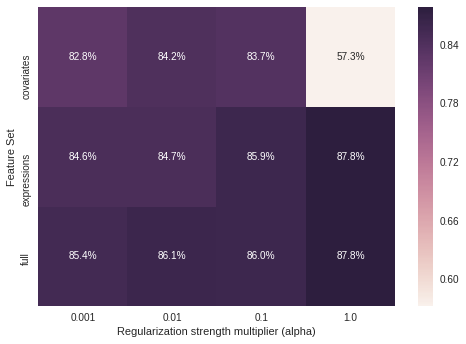

In [17]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results_df,
                              values='mean_test_score', 
                              index='feature_set',
                              columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Feature Set');

## Use optimal hyperparameters to output ROC curve

In [18]:
y_pred_dict = {
    model: {
        'train': pipeline.decision_function(X_train),
        'test':  pipeline.decision_function(X_test)
    } for model, pipeline in cv_pipelines.items()
}

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_dict = {    
    model: {
        'train': get_threshold_metrics(y_train, y_pred_dict[model]['train']),
        'test':  get_threshold_metrics(y_test, y_pred_dict[model]['test'])
    } for model in y_pred_dict.keys()
}

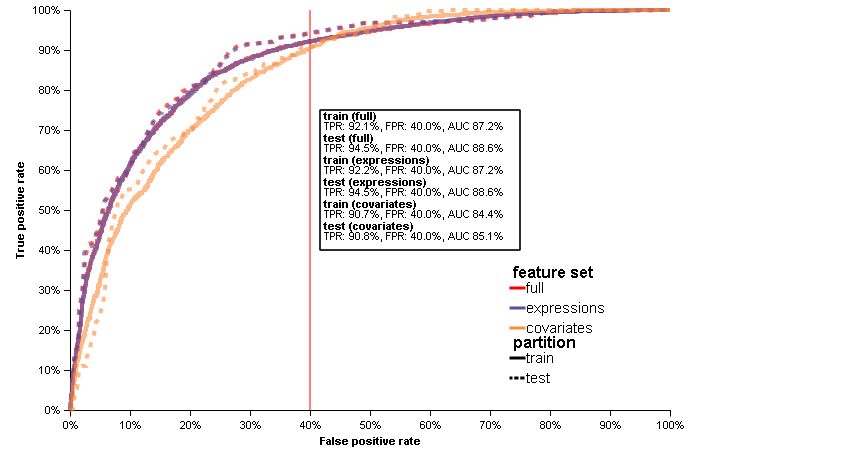

In [19]:
# Assemble the data for ROC curves
model_order = ['full', 'expressions', 'covariates']

auc_output = pd.DataFrame()
roc_output = pd.DataFrame()

for model in model_order:
    metrics_partition = metrics_dict[model]
    for partition, metrics in metrics_partition.items():
        auc_output = auc_output.append(pd.DataFrame({
            'partition': [partition],
            'feature_set': [model],
            'auc': metrics['auroc']
        }))
        roc_df = metrics['roc_df']
        roc_output = roc_output.append(pd.DataFrame({
            'false_positive_rate': roc_df.fpr,
            'true_positive_rate': roc_df.tpr,
            'partition': partition,
            'feature_set': model
        }))
auc_output['legend_index'] = range(len(auc_output.index))

with open('vega_specs/roc_vega_spec.json', 'r') as fp:
    vega_spec = json.load(fp)

final_spec = fill_spec_with_data(vega_spec, 
    {'roc': roc_output, 'legend_auc': auc_output})

Vega(final_spec)

## What are the classifier coefficients?

In [20]:
final_pipelines = {
    model: pipeline.best_estimator_
    for model, pipeline in cv_pipelines.items()
}
final_classifiers = {
    model: pipeline.named_steps['classify']
    for model, pipeline in final_pipelines.items()
}

coef_df = pd.concat([
    get_model_coefficients(classifier, model, covariate_df.columns)
    for model, classifier in final_classifiers.items()
])

In [21]:
# Signs of the coefficients by model
pd.crosstab(coef_df.feature_set, np.sign(coef_df.weight).rename('coefficient_sign'))

coefficient_sign,-1.0,0.0,1.0
feature_set,,,
covariates,15,5,13
expressions,14,74,12
full,13,59,11


### Top coefficients for covariates model

In [22]:
coef_df.query("feature_set == 'full'").head(10)

,feature,weight,abs,feature_set
8,PCA_8,-0.037813,0.037813,full
29,PCA_29,-0.035977,0.035977,full
2,PCA_2,-0.035753,0.035753,full
11,PCA_11,-0.033399,0.033399,full
24,PCA_24,0.032038,0.032038,full
22,PCA_22,-0.030622,0.030622,full
37,PCA_37,0.029145,0.029145,full
1,PCA_1,-0.028273,0.028273,full
17,PCA_17,0.023787,0.023787,full
34,PCA_34,-0.023123,0.023123,full


### Top coefficients for individual _genes_ for full model

In [23]:
pca_for_full = (
    final_pipelines['full']
    .named_steps['features']
    .get_params()['expressions__pca']
    )
classifier_for_full = (
    final_pipelines['full']
    .named_steps['classify']
    )
gene_coefficients_for_full = get_genes_coefficients(
    pca_object=pca_for_full,
    classifier_object=classifier_for_full,
    expression_df=expression_df,
    expression_genes_df=expression_genes_df,
    num_covariates=len(covariate_df.columns)
    )
gene_coefficients_for_full.head(10)

,symbol,weight,abs,description
entrez_id,,,,
1643,DDB2,-0.003416,0.003416,damage specific DNA binding protein 2
8767,RIPK2,0.003296,0.003296,receptor interacting serine/threonine kinase 2
25879,DCAF13,0.003260,0.003260,DDB1 and CUL4 associated factor 13
3654,IRAK1,0.003178,0.003178,interleukin 1 receptor associated kinase 1
79581,SLC52A2,0.003080,0.003080,solute carrier family 52 member 2
157378,TMEM65,0.003072,0.003072,transmembrane protein 65
734,OSGIN2,0.003035,0.003035,oxidative stress induced growth inhibitor fami...
114907,FBXO32,0.003025,0.003025,F-box protein 32
6788,STK3,0.002991,0.002991,serine/threonine kinase 3


### Top coefficients for individual _genes_ for expressions model

In [24]:
pca_for_expression = (
    final_pipelines['expressions']
    .named_steps['features']
    .get_params()['expressions__pca']
    )
classifier_for_expression = (
    final_pipelines['expressions']
    .named_steps['classify']
    )
gene_coefficients_for_expression = get_genes_coefficients(
    pca_object=pca_for_expression,
    classifier_object=classifier_for_expression,
    expression_df=expression_df,
    expression_genes_df=expression_genes_df
    )
gene_coefficients_for_expression.head(10)

,symbol,weight,abs,description
entrez_id,,,,
1643,DDB2,-0.003478,0.003478,damage specific DNA binding protein 2
8767,RIPK2,0.003387,0.003387,receptor interacting serine/threonine kinase 2
25879,DCAF13,0.003345,0.003345,DDB1 and CUL4 associated factor 13
3654,IRAK1,0.003263,0.003263,interleukin 1 receptor associated kinase 1
79581,SLC52A2,0.003148,0.003148,solute carrier family 52 member 2
157378,TMEM65,0.003143,0.003143,transmembrane protein 65
734,OSGIN2,0.003128,0.003128,oxidative stress induced growth inhibitor fami...
6788,STK3,0.003096,0.003096,serine/threonine kinase 3
114907,FBXO32,0.003083,0.003083,F-box protein 32


## Investigate the predictions

In [25]:
predict_df = pd.DataFrame()
for model, pipeline in final_pipelines.items():
    df = pd.DataFrame.from_items([
        ('feature_set', model),
        ('sample_id', X.index),
        ('test_set', X.index.isin(X_test.index).astype(int)),
        ('status', y),
        ('decision_function', pipeline.decision_function(X)),
        ('probability', pipeline.predict_proba(X)[:, 1])
    ])    
    predict_df = predict_df.append(df)

predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [26]:
# Top predictions amongst negatives (potential hidden responders to a targeted cancer therapy)
(predict_df
    .sort_values('decision_function', ascending=False)
    .query("status == 0 and feature_set == 'full'")
    .head(10)
)

,feature_set,sample_id,test_set,status,decision_function,probability,probability_str
sample_id,,,,,,,
TCGA-L5-A4OH-01,full,TCGA-L5-A4OH-01,0,0,3.888922,0.979943,98.0%
TCGA-L5-A8NR-01,full,TCGA-L5-A8NR-01,0,0,3.783796,0.977769,97.8%
TCGA-EI-6513-01,full,TCGA-EI-6513-01,1,0,3.544841,0.971937,97.2%
TCGA-E2-A1LI-01,full,TCGA-E2-A1LI-01,0,0,3.408526,0.967970,96.8%
TCGA-HF-7136-01,full,TCGA-HF-7136-01,0,0,3.397051,0.967612,96.8%
TCGA-21-1081-01,full,TCGA-21-1081-01,0,0,3.261241,0.963075,96.3%
TCGA-L5-A4OS-01,full,TCGA-L5-A4OS-01,0,0,3.215516,0.961414,96.1%
TCGA-B6-A0I1-01,full,TCGA-B6-A0I1-01,0,0,3.142482,0.958611,95.9%
TCGA-BR-A4J1-01,full,TCGA-BR-A4J1-01,0,0,3.102217,0.956984,95.7%


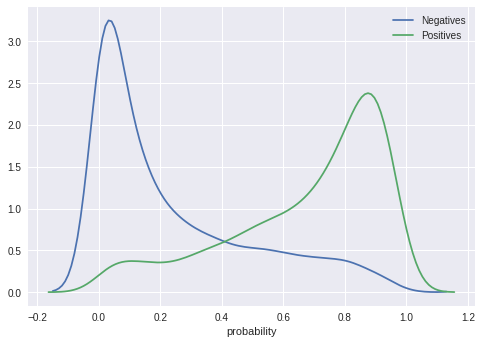

In [27]:
model_predict_df = predict_df.query("feature_set == 'full'")
ax = sns.distplot(model_predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(model_predict_df.query("status == 1").probability, hist=False, label='Positives')